In [1]:
import os
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt


from model_training_ck.models import MobileNetV3, ViT
import numpy as np
from lime import lime_image
from skimage.segmentation import mark_boundaries


/home/diogoalves/thesis/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model_directory = "model_training_ck/distilled_lottery_tickets"
data_directory = "ck_data/"

In [3]:
def load_models(model_directory):
    models = {}
    for model_name in os.listdir(model_directory):
        if model_name.endswith('.pt') or model_name.endswith('.pth'):
            model_path = os.path.join(model_directory, model_name)
            print(model_name)

            if "vit" in model_name.lower():
                model = ViT(num_labels=7)
            else:
                model = MobileNetV3(num_labels=7)
            models[model_name] = model.to('cpu')
    return models

def load_images_with_labels(directory):
    images_with_labels = []

    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])

    for filename in os.listdir(directory):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            label = filename.split('.')[0]

            path = os.path.join(directory, filename)
            image = Image.open(path).convert('RGB')

            input_tensor = preprocess(image).unsqueeze(0)

            images_with_labels.append((input_tensor, label))

    return images_with_labels

def predict_wrapper(model):
    def predict(images):
        transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        ])

        images = torch.stack([transform(image).float() for image in images]).to('cpu')

        with torch.no_grad():
            outputs = model(images)
            if isinstance(outputs, torch.Tensor):
                _, predicted = torch.max(outputs.data, 1)
                predicted = torch.nn.functional.one_hot(predicted, num_classes=outputs.size(1)).float().cpu().numpy()
            else:
                predicted = outputs.logits.cpu().numpy()  # Example: Extract logits if the model output is a named tuple
            return predicted
    return predict

def explain_with_lime(models, image_tensor_label_list, figsize=(12, 6), spacing=0.1):
    """
    Explains the predictions of multiple models using LIME for a list of image tensors and their labels.

    Parameters:
    - models: A dictionary where keys are model names and values are model instances.
    - image_tensor_label_list: A list of tuples, where each tuple contains a preprocessed image tensor and its corresponding label.
    - figsize: A tuple specifying the figure size for each row of images (default is (12, 6)).
    - spacing: A float that controls the amount of spacing between subplots (default is 0.1).
    """
    class_names = sorted(list(set(label for _, label in image_tensor_label_list)))

    grouped_images = {label: [] for label in class_names}
    for input_tensor, label in image_tensor_label_list:
        grouped_images[label].append(input_tensor)

    num_models = len(models)

    for label in class_names:
        image_tensors = grouped_images[label]
        image = image_tensors[0].squeeze(0).permute(1, 2, 0).numpy()

        fig, axes = plt.subplots(1, num_models + 1, figsize=(figsize[0] * (num_models + 1), figsize[1]))

        axes[0].imshow(image)
        axes[0].axis('off')
        axes[0].set_title(f'Original Image\nLabel: {label}', fontsize=45)

        for j, (model_name, model) in enumerate(models.items()):
            explainer = lime_image.LimeImageExplainer()
            explanation = explainer.explain_instance(
                np.array(image),
                predict_wrapper(model),
                top_labels=len(class_names),
                hide_color=0,
                num_samples=1000
            )
            model_name = model_name.replace('.pt', '')
            model_name = model_name.replace('_', ' ')
            try:
                top_label = explanation.top_labels[0]
                if top_label >= len(class_names):
                    top_label = 0
            except IndexError:
                top_label = 0

            top_label = min(top_label, len(class_names) - 1)

            temp, mask = explanation.get_image_and_mask(
                top_label,
                positive_only=False,
                num_features=10,
                hide_rest=False
            )

            axes[j + 1].imshow(mark_boundaries(temp / 2 + 0.5, mask))
            axes[j + 1].axis('off')
            axes[j + 1].set_title(f'{model_name}', fontsize=45)

        plt.subplots_adjust(wspace=spacing)
        plt.savefig(f"lime_explanations/lime_explanations_{label}.png")
        plt.show()


def plot_images_with_labels(image_tensor_label_list):
    """
    Plots images from preprocessed tensors along with their corresponding labels.

    Parameters:
    - image_tensor_label_list: A list of tuples, where each tuple contains a preprocessed image tensor and its corresponding label.
    """
    num_images = len(image_tensor_label_list)
    plt.figure(figsize=(15, 15))

    for i, (input_tensor, label) in enumerate(image_tensor_label_list):
        image = input_tensor.squeeze(0).permute(1, 2, 0).numpy()

        plt.subplot(1, num_images, i + 1)
        plt.imshow(image)
        plt.title(label)
        plt.axis('off')

    plt.show()

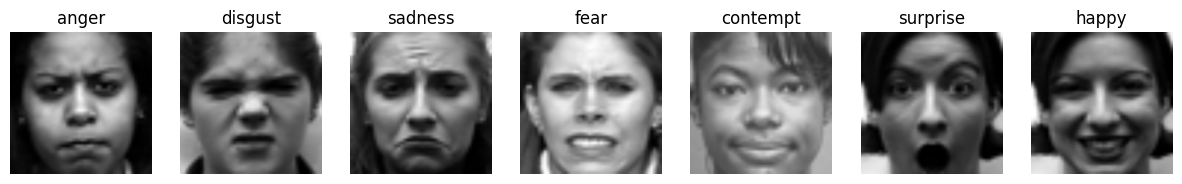

In [4]:
input_tensor = load_images_with_labels(data_directory)

plot_images_with_labels(input_tensor)

In [5]:
models = load_models(model_directory)

distilled_lottery_ticket_590k.pt
distilled_lottery_ticket_1.1M.pt
mobilenetv3.pt
vit.pt


/home/diogoalves/thesis/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/diogoalves/thesis/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


distilled_lottery_ticket_532k.pt
distilled_lottery_ticket_897k.pt


100%|██████████| 1000/1000 [00:04<00:00, 241.21it/s]


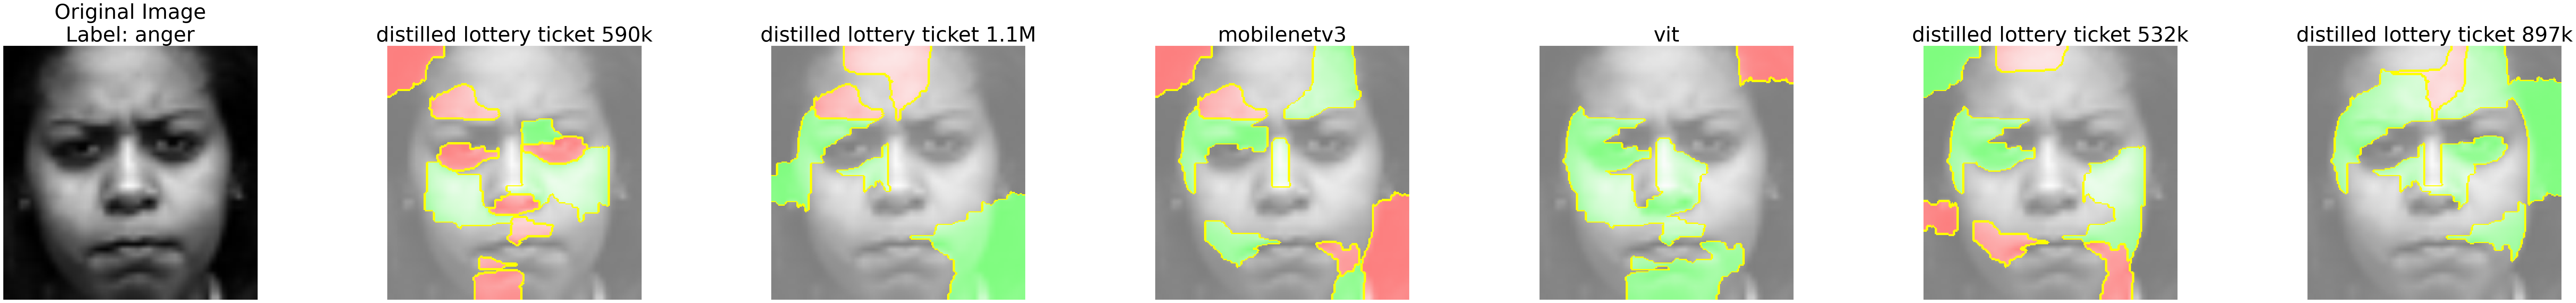

100%|██████████| 1000/1000 [00:04<00:00, 244.49it/s]


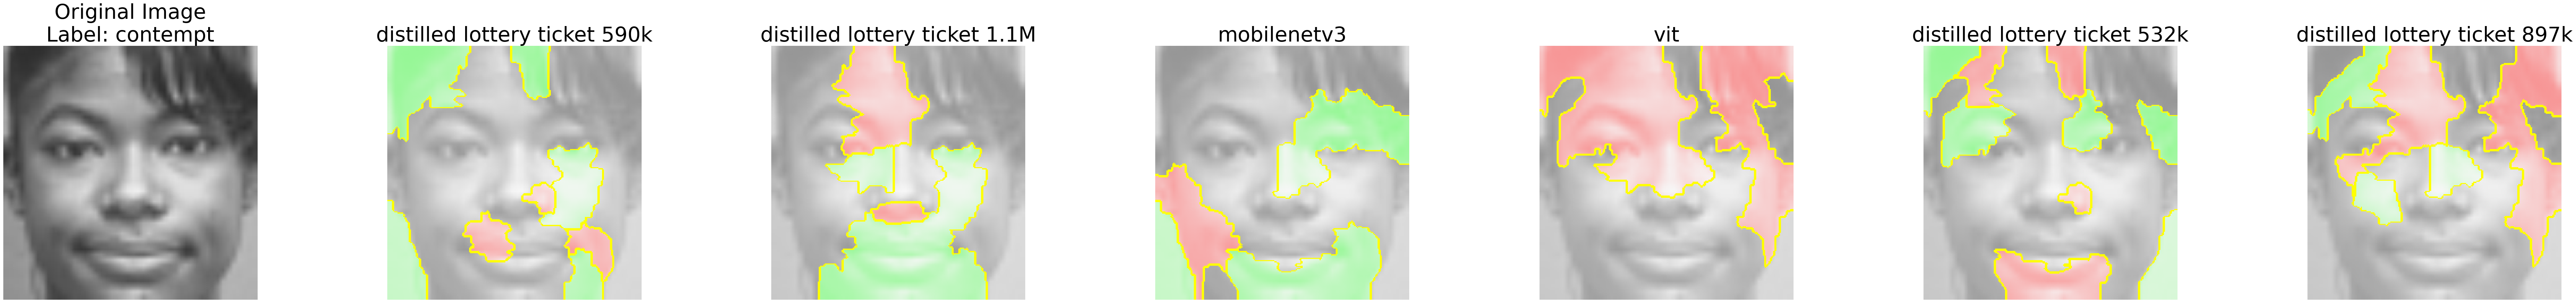

100%|██████████| 1000/1000 [00:04<00:00, 246.11it/s]


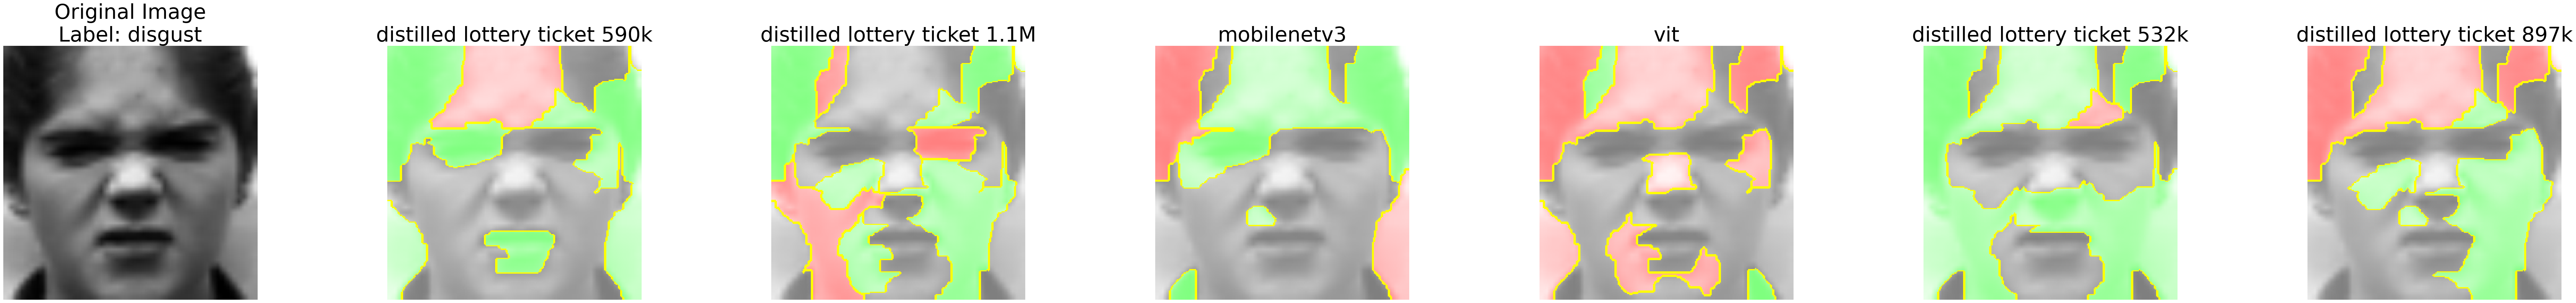

100%|██████████| 1000/1000 [00:04<00:00, 247.07it/s]


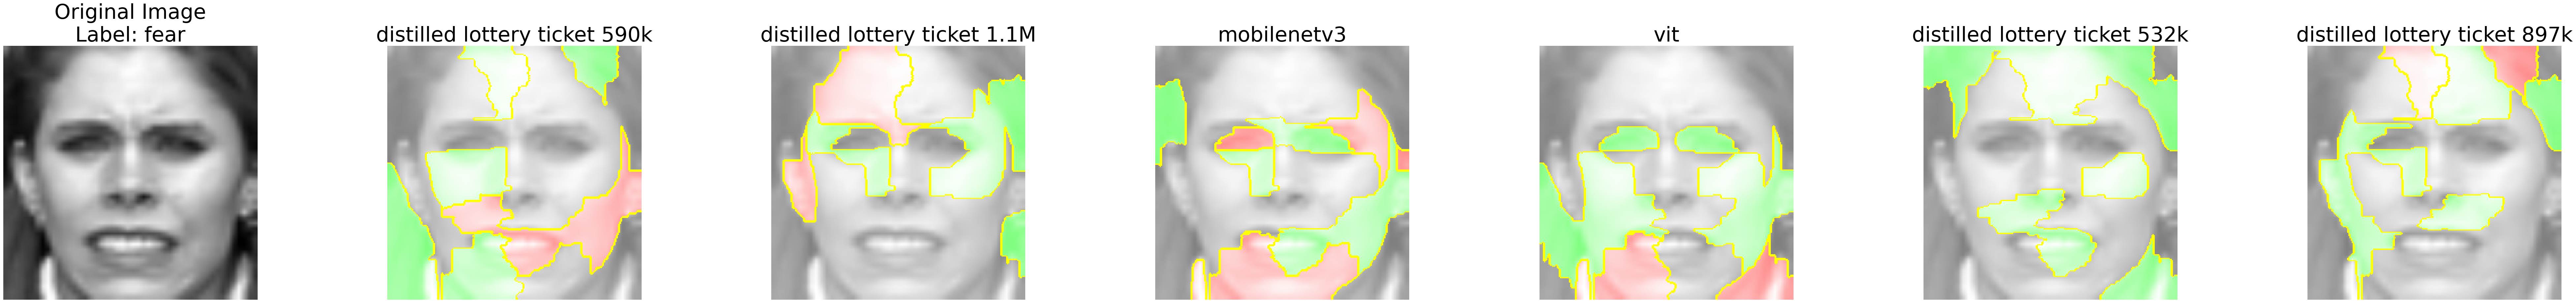

100%|██████████| 1000/1000 [00:04<00:00, 245.25it/s]


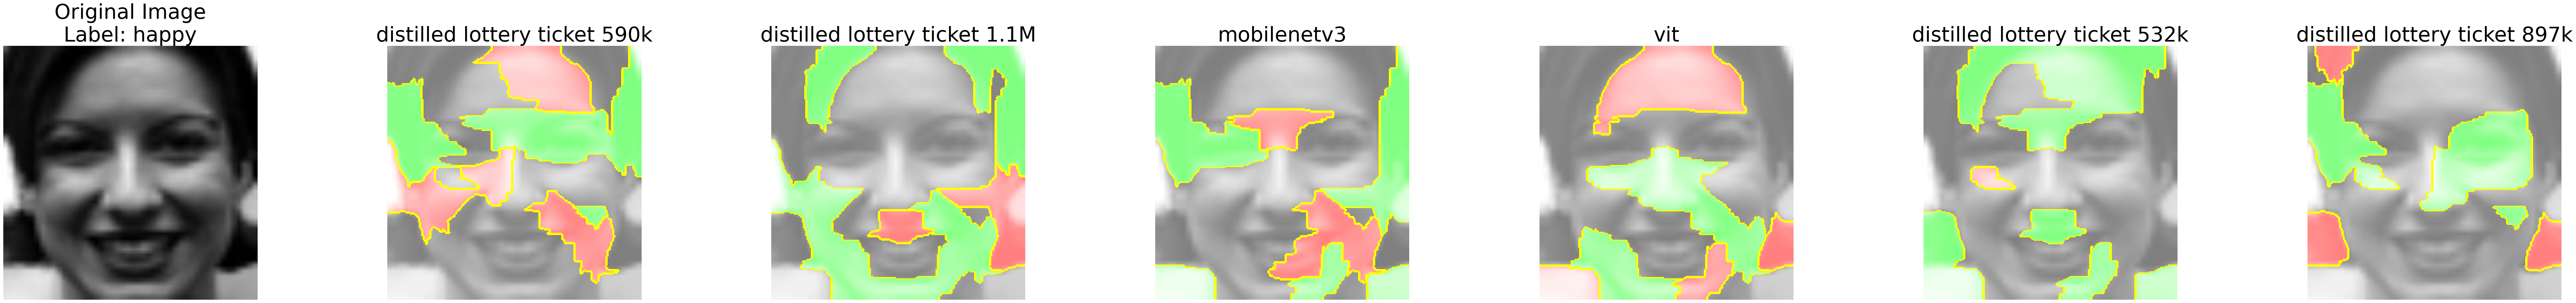

100%|██████████| 1000/1000 [00:04<00:00, 246.28it/s]


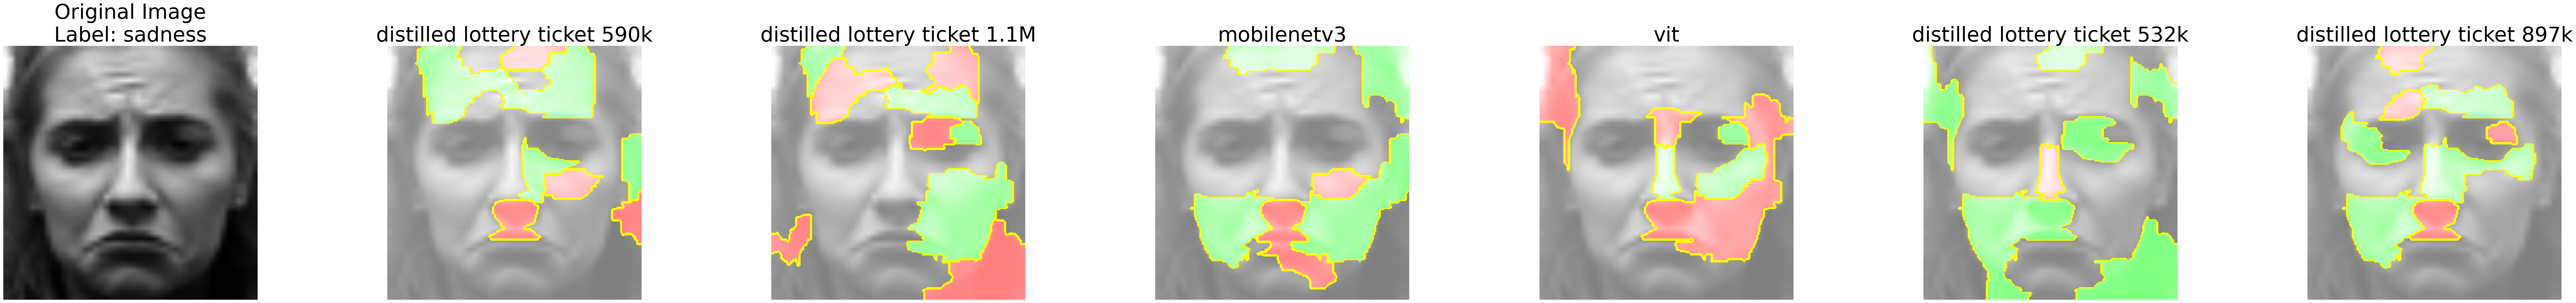

100%|██████████| 1000/1000 [00:04<00:00, 239.06it/s]


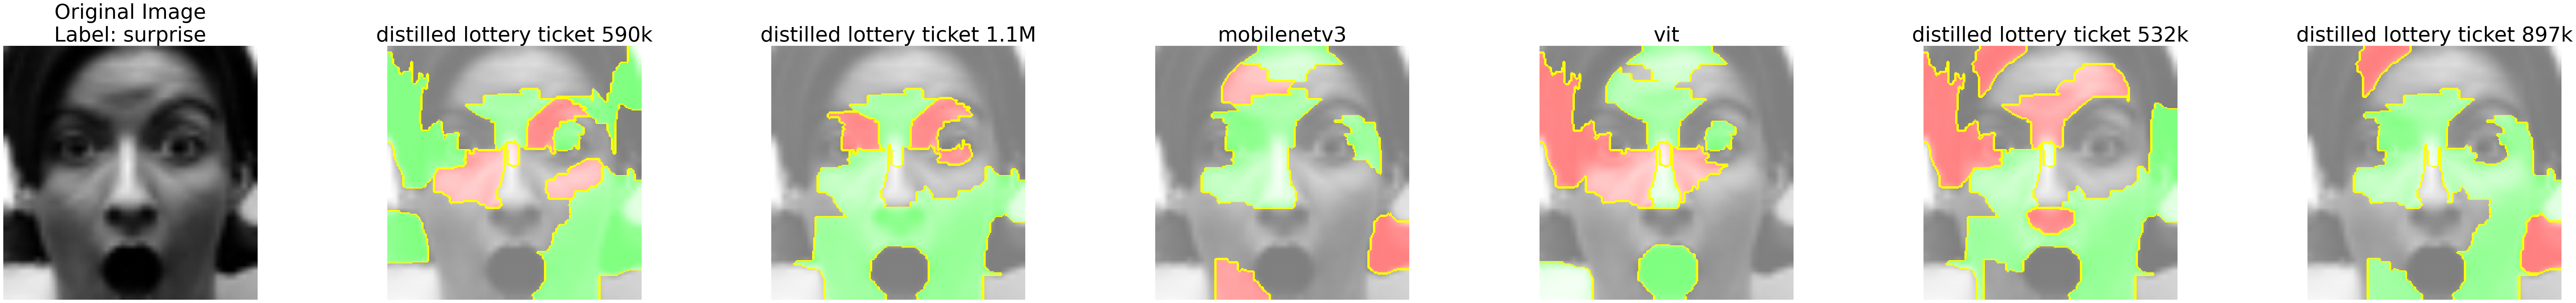

In [6]:
explain_with_lime(models, input_tensor, figsize=(15, 10), spacing=0.01)